## Settings

In [1]:
%cd /content/drive/MyDrive/Dyetec

/content/drive/MyDrive/Dyetec


In [ ]:
!pip install colormath

In [64]:
import os
import random
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
import seaborn as sns

from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cmc

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold

# from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

In [4]:
SEED = 42
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)

seed_everything(SEED)

### Configurations

In [6]:
#=====  XGBoost  =====
BOOSTER = 'gbtree' # default. Gradient Boosting tree
LR = 0.1
MAX_DEPTH = 20
N_ESTIMATORS = 100
OBJECTIVE = 'reg:squarederror'
SILENT = False
SUBSAMPLE = 1.0  # Subsample ratio from the training set

colsample_bylevel = 1.0
colsample_bytree = 1.0
EARLY_STOPPING_ROUNDS = 10  # 에러가 n번 증가하면 학습 중단, default 10
GAMMA = 0.0
MAX_DELTA_STEP = 0.0
min_child_weights = 1.0 # Minimum sum of weights needed in each child node for a split.
num_parallel_tree = 1

# 'dart'인 경우에만 적용 - overfitting 방지
# NORMALIZE_TYPE = 'tree'  # how to normalize trees, default 'tree'
# ONE_DROP = True          # 1개 이상의 트리를 드롭아웃
# RATE_DROP = 0.5          # 각 트리를 드롭아웃할 확률, default 0.0
# REG_ALPHA = 0.2          # L1 regularization on the weights, default 0.0
# REG_LAMBDA = 0.8         # L2 regularization on the weights, default 1.0
# SAMPLE_TYPE = 'weighted' # 드롭아웃 확률을 트리의 가중치에 비례하게, default 'uniform'
# SKIP_DROP = 0.2          # skipping the dropout during a given iteration, default 0.0

In [7]:
model_xgb = MultiOutputRegressor(xgb.XGBRegressor(
    booster=BOOSTER, # 'dart': Adds dropout to the standard gradient boosting algorithm
    learning_rate=LR,
    max_depth=MAX_DEPTH,
    n_estimators=N_ESTIMATORS,
    objective=OBJECTIVE,
    silent=SILENT,
    subsample=SUBSAMPLE,
))

In [8]:
def train_total(X_train, X_test, y_train, y_test, model):
    print('Train:', X_train.shape, y_train.shape)
    print('Test :', X_test.shape, y_test.shape)

    # Model Training - XGBoost
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    df_train_pred = pd.DataFrame(y_train_pred, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

    # Prediction
    y_pred = model.predict(X_test)
    df_pred = pd.DataFrame(y_pred, columns=['L', 'a', 'b'])

    # Performance Evaluation
    print(f'\n[Train] R-squared: {round(model.score(X_train, y_train),5)}')
    print(f'[Test]  R-squared: {round(model.score(X_test, y_test),5)}')
    print(f'[Train] MSE: {round(mean_squared_error(y_train, y_train_pred), 4)}')
    print(f'[Test]  MSE: {round(mean_squared_error(y_test, y_pred),4)}')

    # Train Dataset
    df_train_pred['Delta_E'] = compute_delta_e(y_train, y_train_pred)
    df_train_pred['Below 1'] = (df_train_pred['Delta_E'] < 1)
    print(f"\n[Train] ΔE < 1 : {df_train_pred['Below 1'].sum()} / {len(df_train_pred)} = {df_train_pred['Below 1'].mean():.4f}")
    print(f"[Train] Average of ΔE : {df_train_pred['Delta_E'].mean():.4f}")

    # Test Dataset
    df_pred['Delta_E_total'] = compute_delta_e(y_test, y_pred)
    df_pred['Below 1_total'] = (df_pred['Delta_E_total'] < 1)
    print(f"[Test]  ΔE < 1 : {df_pred['Below 1_total'].sum()} / {len(df_pred)} = {df_pred['Below 1_total'].mean():.4f}")
    print(f"[Test]  Average of ΔE : {df_pred['Delta_E_total'].mean():.4f}")

    return df_train_pred, df_pred, model

In [9]:
def compute_delta_e(y_test, y_pred):
    delta_E = []
    for i, (L_pred, a_pred, b_pred) in enumerate(y_pred):
        L_test, a_test, b_test = y_test.iloc[i].values
        target_color = LabColor(L_test, a_test, b_test)
        pred_color = LabColor(L_pred, a_pred, b_pred)
        delta_E.append(delta_e_cmc(target_color, pred_color, pl=2, pc=1))
    return delta_E

## Data Loading

In [ ]:
# df = pd.read_excel('rawdata.xlsx', sheet_name='원본', skiprows=2)
# df.drop(labels=0, inplace=True)
# df.reset_index(inplace=True)
# df.drop(columns=['index','태그'], inplace=True)
# df.head(3)

In [11]:
df = pd.read_csv('df_remove_prepost.csv')
df

,Doro Yellow,Doro Red,Doro Blue,Doro Yellow_prop,Doro Red_prop,Doro Blue_prop,Doro Black,Doro Grey,Doro Brown,Doro Black_prop,Doro Grey_prop,Doro Brown_prop,Dia Yellow,Dia Red,Dia Blue,Dia Yellow_prop,Dia Red_prop,Dia Blue_prop,Dia Black,Dia Grey,Dia Brown,Dia Black_prop,Dia Grey_prop,Dia Brown_prop,Syno Yellow,Syno Red,Syno Blue,Syno Yellow_prop,Syno Red_prop,Syno Blue_prop,Syno Black,Syno Grey,Syno Brown,Syno Black_prop,Syno Grey_prop,Syno Brown_prop,comb_Sunsolt,comb_acid,comb_UVK200,comb_Fadex,comb_Sera Fast,comb_UVK400,dye_start_temp,dye_up_rate1,dye_up_temp1,dye_up_temp1_hold,dye_up_rate2,dye_up_temp2,dye_up_temp2_hold,dye_up_rate3,dye_up_temp3,dye_up_temp3_hold,dye_down_rate1,dye_down_temp1,dye_down_temp1_hold,dye_down_rate2,dye_down_temp2,dye_down_temp2_hold,dye_down_rate3,dye_down_temp3,dye_down_temp3_hold,dye_end_rate,dye_end_temp,dye_end_temp_hold,L*,a*,b*
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.3,0.5,0.0,0.0,0.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.500000,136.0,60.0,2.00000,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,50.510,10.5500,9.480
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.3,0.5,0.0,4.0,4.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.500000,136.0,60.0,2.00000,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,51.460,10.0100,9.790
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.3,0.5,4.0,0.0,0.0,4.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.500000,136.0,60.0,2.00000,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,51.870,10.2400,9.480
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.3,0.5,0.0,0.0,0.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.500000,136.0,60.0,2.00000,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,48.930,10.9200,9.570
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.3,0.5,0.0,4.0,4.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.500000,136.0,60.0,2.00000,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,49.580,10.5200,9.790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,4.0,2.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.2,0.0,0.0,0.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.458333,135.0,70.0,1.97222,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,48.260,57.3950,50.385
1680,4.0,2.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.2,0.0,0.0,0.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.458333,135.0,80.0,1.97222,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,48.250,57.0850,50.180
1681,6.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.2,0.0,0.0,0.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.458333,135.0,60.0,1.97222,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,69.100,30.2775,84.880
1682,6.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.2,0.0,2.0,0.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.458333,135.0,60.0,1.97222,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,69.835,29.0850,84.570


### 컬럼명 변경

In [11]:
# 염료 브랜드 컬럼명 변경
from collections import defaultdict
newcols = defaultdict(str)

for col in df.columns[70:88].tolist() + df.columns[-21:-3].tolist():
    c = col.replace('Dorosperse','Doro')
    c = c.replace('Dianix', 'Dia')
    c = c.replace('Synolon', 'Syno').replace('Synofast', 'Syno')
    c = c.replace('B/K', 'Black')
    c = c.replace('Dark ', '')
    c = c.replace('28', 'Brown').replace('Yellow Brown', 'Brown')
    if 'prop' not in c or 'Syno Brown' in c: 
        c = ' '.join(c.split()[:2])
    else:
        c = ' '.join(c.split()[:2]) + '_prop'
    newcols[col] = c

df.rename(columns=newcols, inplace=True)

In [12]:
kr2en = {
        #  '전처리_CH3COOH': 'prep_CH3COOH', 
        #  '제직_중량_생지': 'weaving_dough', 
         '배합_Sunsolt RM-340S': 'comb_Sunsolt',
         '배합_빙초산': 'comb_acid',
         '배합_UVK-200': 'comb_UVK200',
         '배합_Fadex® TS liq': 'comb_Fadex', 
         '배합_Sera Fast P-UVC': 'comb_Sera Fast', 
         '배합_UVK-400 H/C': 'comb_UVK400', 
         'Lab 염색 시작온도': 'dye_start_temp',
         'Lab 염색 상승속도 #1': 'dye_up_rate1', 
         'Lab 염색 상승온도 #1': 'dye_up_temp1', 
         'Lab 염색 상승온도 #1 유지시간': 'dye_up_temp1_hold',
         'Lab 염색 상승속도 #2': 'dye_up_rate2', 
         'Lab 염색 상승온도 #2': 'dye_up_temp2', 
         'Lab 염색 상승온도 #2 유지시간': 'dye_up_temp2_hold',
         'Lab 염색 상승속도 #3': 'dye_up_rate3', 
         'Lab 염색 상승온도 #3': 'dye_up_temp3', 
         'Lab 염색 상승온도 #3 유지시간': 'dye_up_temp3_hold',
         'Lab 염색 하강속도 #1': 'dye_down_rate1', 
         'Lab 염색 하강온도 #1': 'dye_down_temp1', 
         'Lab 염색 하강온도 #1 유지시간': 'dye_down_temp1_hold',
         'Lab 염색 하강속도 #2': 'dye_down_rate2', 
         'Lab 염색 하강온도 #2': 'dye_down_temp2', 
         'Lab 염색 하강온도 #2 유지시간': 'dye_down_temp2_hold',
         'Lab 염색 하강속도 #3': 'dye_down_rate3', 
         'Lab 염색 하강온도 #3': 'dye_down_temp3', 
         'Lab 염색 하강온도 #3 유지시간': 'dye_down_temp3_hold',
         'Lab 염색 종료속도': 'dye_end_rate', 
         'Lab 염색 종료온도': 'dye_end_temp', 
         'Lab 염색 종료온도 유지시간': 'dye_end_temp_hold',
        #  '후처리_Sera Con M-FAS': 'after_Sera', 
        #  '후처리_NaOH': 'after_NaOH'
         'Lab 후가공 후 검사_L*': 'L*', 
         'Lab 후가공 후 검사_a*': 'a*', 
         'Lab 후가공 후 검사_b*': 'b*',
}

df.rename(columns=kr2en, inplace=True)
# df.head(3)

### 공정별 변수 그룹화
- 섬유 전처리 70개 (경사, 위사, 제직 등)
- 염료 투입량 18개 + 배합 화합물 6개 = 24개
- 염색 상승/하강 온도, 속도, 유지시간 22개
- 염색 후처리/후가공 관련 36개 (NaOH, 환원세정제 등)
- [파생변수] 염료 구성비 18개
- 타겟변수 3개 (L, a, b)

In [13]:
pre = df.columns[:70].tolist()      # 섬유 전처리 70개 (Pre-process)
form = df.columns[70:94].tolist()   # 염료 배합/조제 24개 (Dye Formulation)
dye = df.columns[94:116].tolist()   # 염색 공정 22개 (Dyeing)
post = df.columns[116:152].tolist() # 후처리/후가공 36개 (Post-process)
prop = df.columns[152:-3].tolist()  # 염료 구성비 파생변수 18개 (Proportion)
Lab = df.columns[-3:].tolist()      # 타겟변수 3개 (L*, a*, b*)

len(pre), len(form), len(dye), len(post), len(prop), len(Lab)

(70, 24, 22, 36, 18, 3)

섬유 전처리, 후처리 공정은 거의 고정값이므로 제거한다.  (173개 -> 67개)

In [14]:
df.drop(columns=pre, inplace=True)
df.drop(columns=post, inplace=True)
df.shape

(1684, 67)

### 컬럼 순서 재정렬
: 염료 투입량 - 염료 구성비(브랜드별) - 배합 화합물 - 염색 공정

In [15]:
# 브랜드별 염료 투입량 - 구성비 순서로 정렬
df = pd.concat([df[form[:-6]], df[prop], df[form[-6:]], df[dye], df[Lab]], axis=1)
df_doro = pd.concat([df.iloc[:, :3], df.iloc[:, 18:21], df.iloc[:, [9,12,16]], df.iloc[:, [27,30,34]]], axis=1)
df_dia  = pd.concat([df.iloc[:, 3:6], df.iloc[:, 21:24], df.iloc[:, [10,13,15]], df.iloc[:, [28,31,33]]], axis=1)
df_syno  = pd.concat([df.iloc[:, 6:9], df.iloc[:, 24:27], df.iloc[:, [11,14,17]], df.iloc[:, [29,32,35]]], axis=1)
df_dyes = pd.concat([df_doro, df_dia, df_syno], axis=1)
# df_dyes

In [16]:
df = pd.concat([df_dyes, df[form[-6:]], df[dye], df[Lab]], axis=1)
df.head()

,Doro Yellow,Doro Red,Doro Blue,Doro Yellow_prop,Doro Red_prop,Doro Blue_prop,Doro Black,Doro Grey,Doro Brown,Doro Black_prop,Doro Grey_prop,Doro Brown_prop,Dia Yellow,Dia Red,Dia Blue,Dia Yellow_prop,Dia Red_prop,Dia Blue_prop,Dia Black,Dia Grey,Dia Brown,Dia Black_prop,Dia Grey_prop,Dia Brown_prop,Syno Yellow,Syno Red,Syno Blue,Syno Yellow_prop,Syno Red_prop,Syno Blue_prop,Syno Black,Syno Grey,Syno Brown,Syno Black_prop,Syno Grey_prop,Syno Brown_prop,comb_Sunsolt,comb_acid,comb_UVK200,comb_Fadex,comb_Sera Fast,comb_UVK400,dye_start_temp,dye_up_rate1,dye_up_temp1,dye_up_temp1_hold,dye_up_rate2,dye_up_temp2,dye_up_temp2_hold,dye_up_rate3,dye_up_temp3,dye_up_temp3_hold,dye_down_rate1,dye_down_temp1,dye_down_temp1_hold,dye_down_rate2,dye_down_temp2,dye_down_temp2_hold,dye_down_rate3,dye_down_temp3,dye_down_temp3_hold,dye_end_rate,dye_end_temp,dye_end_temp_hold,L*,a*,b*
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.3,0.5,0.0,0.0,0.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.5,136.0,60.0,2.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,50.51,10.55,9.48
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.3,0.5,0.0,4.0,4.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.5,136.0,60.0,2.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,51.46,10.01,9.79
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.3,0.5,4.0,0.0,0.0,4.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.5,136.0,60.0,2.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,51.87,10.24,9.48
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.3,0.5,0.0,0.0,0.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.5,136.0,60.0,2.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,48.93,10.92,9.57
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.3,0.5,0.0,4.0,4.0,0.0,40.0,1.5,64.0,0.0,0.75,100.0,0.0,1.5,136.0,60.0,2.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,0.0,64.0,0.0,49.58,10.52,9.79


데이터 저장 (컬럼 67개)

In [110]:
# df.to_csv('df_remove_prepost.csv', index=False)

## EDA

In [15]:
df.nunique()

Doro Yellow              21
Doro Red                 21
Doro Blue                21
Doro Yellow_prop         18
Doro Red_prop            18
Doro Blue_prop           18
Doro Black               12
Doro Grey                12
Doro Brown               12
Doro Black_prop           2
Doro Grey_prop            2
Doro Brown_prop           2
Dia Yellow               21
Dia Red                  21
Dia Blue                 21
Dia Yellow_prop          18
Dia Red_prop             18
Dia Blue_prop            18
Dia Black                12
Dia Grey                 12
Dia Brown                12
Dia Black_prop            2
Dia Grey_prop             2
Dia Brown_prop            2
Syno Yellow              21
Syno Red                 21
Syno Blue                21
Syno Yellow_prop         18
Syno Red_prop            18
Syno Blue_prop           18
Syno Black               12
Syno Grey                12
Syno Brown               12
Syno Black_prop           2
Syno Grey_prop            2
Syno Brown_prop     

In [12]:
df['Doro Yellow'].value_counts()

0.000    1415
2.000      49
0.667      31
0.017      27
0.033      24
6.000      22
1.333      21
0.050      20
4.000      20
1.000      12
0.333      10
0.500       8
0.167       6
0.067       4
0.833       3
0.100       2
1.500       2
2.500       2
3.000       2
1.667       2
2.667       2
Name: Doro Yellow, dtype: int64

In [13]:
df['Doro Yellow_prop'].value_counts()

0.000000    1415
1.000000      84
0.333333      59
0.666667      22
0.340000      18
0.660000      18
0.666500      18
0.333500      18
0.667000       4
0.333000       4
0.666000       4
0.334000       4
0.670000       4
0.330000       4
0.333200       2
0.333250       2
0.666800       2
0.666750       2
Name: Doro Yellow_prop, dtype: int64

In [120]:
df['Dia Black'].value_counts()

0.00    1593
6.00      25
2.00      24
0.05      19
4.00       7
1.00       6
3.00       3
5.00       3
0.10       1
0.50       1
1.50       1
2.50       1
Name: Dia Black, dtype: int64

In [121]:
df['Dia Black_prop'].value_counts()

0.0    1593
1.0      91
Name: Dia Black_prop, dtype: int64

- Black, Grey, Brown 염료는 단독 투입
- Yellow, Red, Blue 염료는 단독/혼합 투입 \
  (같은 브랜드에서 제조한 Yellow, Red, Blue 색상끼리 혼합)

In [122]:
# 염색 공정 변수 22개 (상승/하강 온도, 속도, 유지시간)
print(f"시작온도 : {np.array(df.nunique())[42]} -> 고정값")
print(f"\n상승 #1 (속도, 온도, 유지시간): {np.array(df.nunique())[43:46]}")
print(f"상승 #2 (속도, 온도, 유지시간): {np.array(df.nunique())[46:49]}")
print(f"상승 #3 (속도, 온도, 유지시간): {np.array(df.nunique())[49:52]} -> 유지시간 10~80분")

print(f"\n하강 #1 (속도, 온도, 유지시간): {np.array(df.nunique())[52:55]} -> 하강속도 1.972 vs 2.0")
print(f"하강 #2 (속도, 온도, 유지시간): {np.array(df.nunique())[55:58]}")
print(f"하강 #3 (속도, 온도, 유지시간): {np.array(df.nunique())[58:61]}")

print(f"\n종료 (속도, 온도, 유지시간): {np.array(df.nunique())[61:64]} -> 고정값")

시작온도 : 1 -> 고정값

상승 #1 (속도, 온도, 유지시간): [2 1 1]
상승 #2 (속도, 온도, 유지시간): [3 1 1]
상승 #3 (속도, 온도, 유지시간): [6 5 8] -> 유지시간 10~80분

하강 #1 (속도, 온도, 유지시간): [2 1 1] -> 하강속도 1.972 vs 2.0
하강 #2 (속도, 온도, 유지시간): [1 1 1]
하강 #3 (속도, 온도, 유지시간): [1 1 1]

종료 (속도, 온도, 유지시간): [1 1 1] -> 고정값


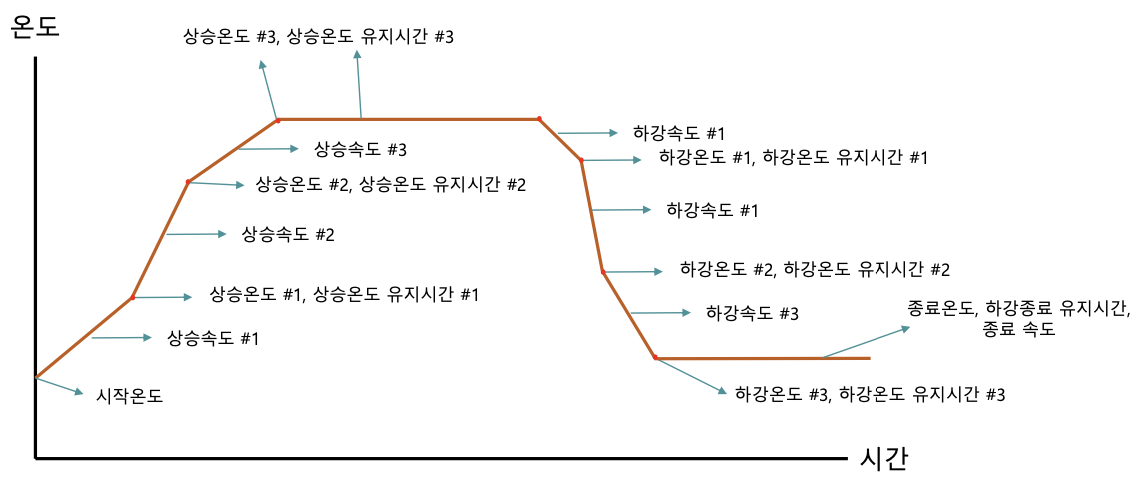

In [128]:
df['dye_down_temp3_hold'].value_counts()

0.0    1684
Name: dye_down_temp3_hold, dtype: int64

- 염색 시작온도, 종료 속도/온도/유지시간은 고정값이므로 제거해서 학습해보기
- 상승/하강 온도 유지시간이 1가지 값이면 전부 0을 의미. 즉, 상승 #3 제외하면 온도를 유지하지 않음.

## 모델 학습

### Lab 한꺼번에 예측 (지난 주)
입력변수 64개
- 배합 공정: 18 + 18 + 6 = 42개
- 염색 공정: 22개

In [30]:
X = df.iloc[:, :-3]
y = df.iloc[:, -3:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
df_train_pred_origin, df_pred_origin, model = train_total(X_train, X_test, y_train, y_test, model_xgb)

Train: (1347, 64) (1347, 3)
Test : (337, 64) (337, 3)

[Train] R-squared: 0.99996
[Test]  R-squared: 0.98235
[Train] MSE: 0.021
[Test]  MSE: 8.6446

[Train] ΔE < 1 : 1346 / 1347 = 0.9993
[Train] Average of ΔE : 0.0989
[Test]  ΔE < 1 : 204 / 337 = 0.6053
[Test]  Average of ΔE : 1.4829


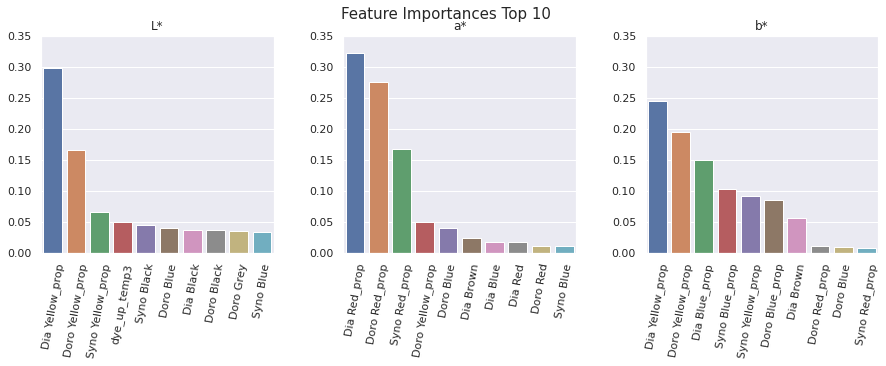

In [31]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')

topN = 10
fig.suptitle(f'Feature Importances Top {topN}', fontsize=15)

for i, ax in enumerate(axes):
    importances = model.estimators_[i].feature_importances_
    indices = np.argsort(importances)[::-1]

    g = sns.barplot(ax=ax, x=list(range(topN)), y=importances[indices[:topN]])
    g.set_xticks(range(topN))
    g.set_xticklabels(X_train.columns[indices[:topN]], rotation=80)
    g.set_title(y.columns[i])
    g.set_ylim(0, 0.35)

plt.show()

**주요 변수**
- L* (밝기) : 세 브랜드(특히 Dianix) 노란색 염료 구성비, 염색 상승온도 #3
- a* (적녹) : 세 브랜드 빨간색 염료 구성비가 압도적으로 높음
- b* (황청) : 세 브랜드 노란색, 파란색 염료 구성비

In [34]:
# 변수 중요도 전체
for i in range(3):
    importances = np.round(model.estimators_[i].feature_importances_, 2)
    indices = np.argsort(importances)[::-1]
    print(f'\nFeature Importances for {y.columns[i]}')
    print(list(zip(X_train.columns[indices], importances[indices])))
    


Feature Importances for L*
[('Dia Yellow_prop', 0.3), ('Doro Yellow_prop', 0.17), ('Syno Yellow_prop', 0.07), ('dye_up_temp3', 0.05), ('Syno Black', 0.05), ('Doro Blue', 0.04), ('Doro Black', 0.04), ('Doro Grey', 0.04), ('Dia Black', 0.04), ('Syno Grey', 0.03), ('Syno Blue', 0.03), ('Dia Grey', 0.03), ('Dia Blue', 0.03), ('Dia Red', 0.02), ('Doro Red', 0.02), ('Dia Brown', 0.02), ('Syno Brown', 0.01), ('Doro Brown', 0.01), ('Syno Red', 0.01), ('Doro Brown_prop', 0.0), ('Dia Brown_prop', 0.0), ('Syno Red_prop', 0.0), ('Doro Red_prop', 0.0), ('Syno Yellow', 0.0), ('Dia Black_prop', 0.0), ('Dia Grey_prop', 0.0), ('Dia Yellow', 0.0), ('Doro Blue_prop', 0.0), ('Dia Blue_prop', 0.0), ('Dia Red_prop', 0.0), ('Doro Black_prop', 0.0), ('Doro Grey_prop', 0.0), ('Syno Blue_prop', 0.0), ('dye_end_temp_hold', 0.0), ('dye_end_temp', 0.0), ('Syno Black_prop', 0.0), ('dye_end_rate', 0.0), ('dye_down_temp3_hold', 0.0), ('dye_down_temp3', 0.0), ('dye_down_rate3', 0.0), ('dye_down_temp2_hold', 0.0), ('d

### K-fold cross validation

In [19]:
NFOLD = 5
kfold = KFold(n_splits=NFOLD, shuffle=True, random_state=SEED)
kfold_preds, kfold_importances, kfold_indices = [], [], []

for i, (train_id, test_id) in enumerate(kfold.split(X, y)):
    X_train, X_test = X.iloc[train_id, :], X.iloc[test_id, :]
    y_train, y_test = y.iloc[train_id, :], y.iloc[test_id, :]

    print(f'\n=======  Fold {i}  =======')
    _, df_pred, model = train_total(X_train, X_test, y_train, y_test, model_xgb)
    kfold_preds.append(df_pred)

    # Feature Importances
    importances = [model.estimators_[i].feature_importances_ for i in range(y.shape[1])]
    indices = [np.argsort(imp)[::-1] for imp in importances]
    kfold_importances.append(importances)
    kfold_indices.append(indices)
    


=======  Fold 0  =======
Train: (1347, 64) (1347, 3)
Test : (337, 64) (337, 3)

[Train] R-squared: 0.99996
[Test]  R-squared: 0.98235
[Train] MSE: 0.021
[Test]  MSE: 8.6446

[Train] ΔE < 1 : 1346 / 1347 = 0.9993
[Train] Average of ΔE : 0.0989
[Test]  ΔE < 1 : 204 / 337 = 0.6053
[Test]  Average of ΔE : 1.4829

=======  Fold 1  =======
Train: (1347, 64) (1347, 3)
Test : (337, 64) (337, 3)

[Train] R-squared: 0.99996
[Test]  R-squared: 0.97645
[Train] MSE: 0.0204
[Test]  MSE: 15.4233

[Train] ΔE < 1 : 1341 / 1347 = 0.9955
[Train] Average of ΔE : 0.1004
[Test]  ΔE < 1 : 227 / 337 = 0.6736
[Test]  Average of ΔE : 1.5541

=======  Fold 2  =======
Train: (1347, 64) (1347, 3)
Test : (337, 64) (337, 3)

[Train] R-squared: 0.99995
[Test]  R-squared: 0.97984
[Train] MSE: 0.0228
[Test]  MSE: 12.5469

[Train] ΔE < 1 : 1340 / 1347 = 0.9948
[Train] Average of ΔE : 0.0998
[Test]  ΔE < 1 : 217 / 337 = 0.6439
[Test]  Average of ΔE : 1.3855

=======  Fold 3  =======
Train: (1347, 64) (1347, 3)
Test : (3

5 Folds 전체 예측 결과

In [25]:
# prediction 합치기
df_preds_all = pd.concat([pred for pred in kfold_preds])  # 인덱스 리셋 안 되어 있음.

print(f"[ALL]  ΔE < 1 : {df_preds_all['Below 1_total'].sum()} / {len(df_preds_all)} = {df_preds_all['Below 1_total'].mean():.4f}")
print(f"[ALL]  Average of ΔE : {df_preds_all['Delta_E_total'].mean():.4f}")

[ALL]  ΔE < 1 : 1095 / 1684 = 0.6502
[ALL]  Average of ΔE : 1.4472


,L,a,b,Delta_E_total,Below 1_total
0,50.548687,10.362143,9.425754,0.702792,True
1,50.826843,10.491465,9.497363,0.375665,True
2,50.305382,10.571717,9.502634,0.469724,True
3,49.992390,10.708449,9.333366,0.452961,True
4,50.514881,10.423005,9.441944,0.731755,True
...,...,...,...,...,...
331,23.181147,5.573032,2.170955,0.202172,True
332,44.943211,59.984947,37.612270,1.307849,False
333,31.208372,-15.856052,16.960947,3.073465,False
334,31.101664,-15.685545,17.811428,0.228736,True


Feature Importances

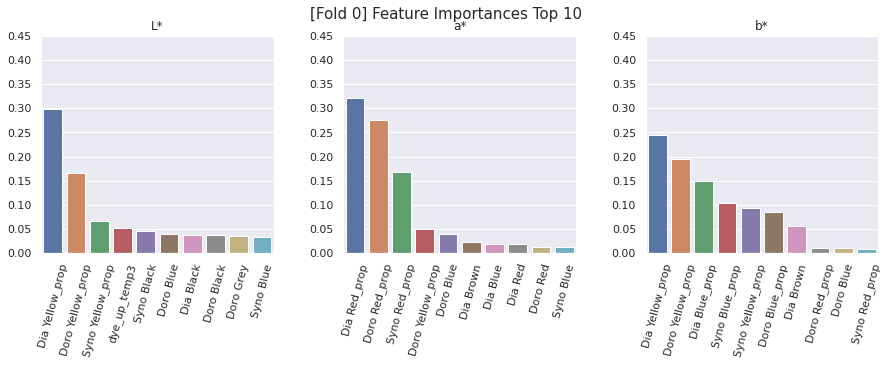

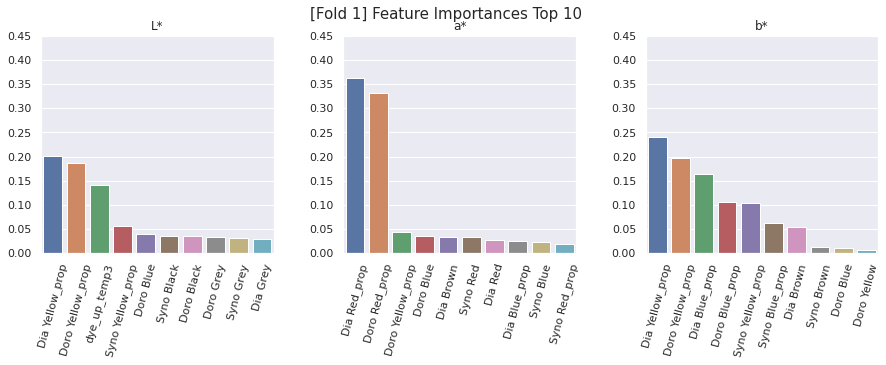

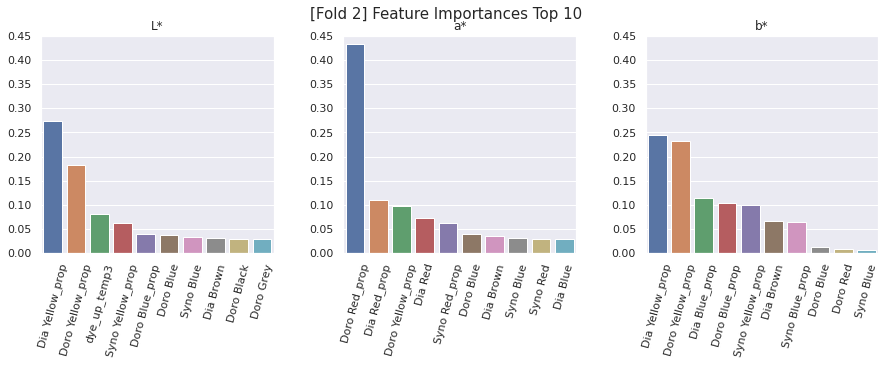

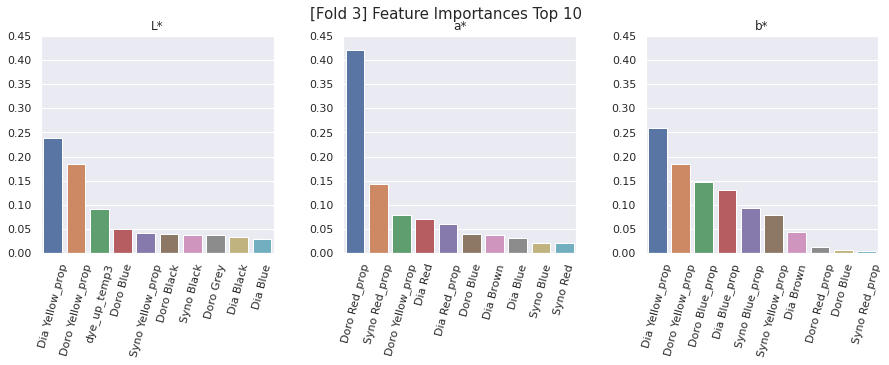

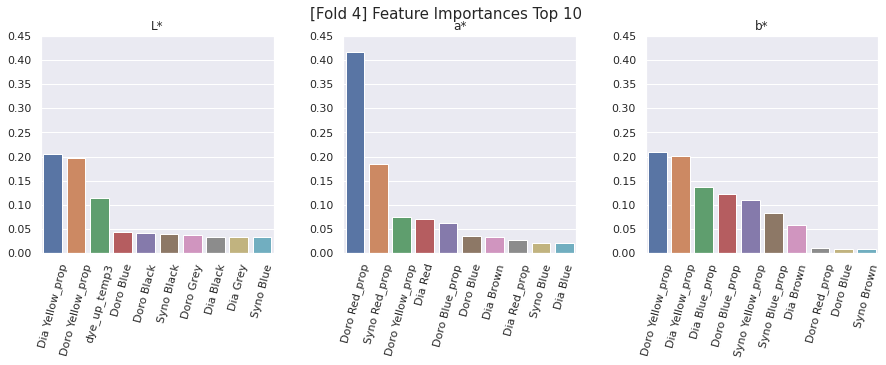

In [28]:
topN = 10
for k in range(NFOLD):
    fig, axes = plt.subplots(1,3, figsize=(15,4))
    plt.subplots_adjust(wspace=0.3)
    sns.set_theme(style='darkgrid')
    fig.suptitle(f'[Fold {k}] Feature Importances Top {topN}', fontsize=15)

    for i, ax in enumerate(axes):
        importances = kfold_importances[k][i]
        indices = kfold_indices[k][i]

        g = sns.barplot(ax=ax, x=list(range(topN)), y=importances[indices[:topN]])
        g.set_xticks(range(topN))
        g.set_xticklabels(X_train.columns[indices[:topN]], rotation=75)
        g.set_title(y.columns[i])
        g.set_ylim(0, 0.45)

    plt.show()

- L* : Dianix Yellow 비율 > Dorosperse Yellow 비율 > 염색 상승온도 #3 > Synolon Yellow 비율, Dorosperse Blue
- a* : Dianix, Dorosperse Red 비율 >> Dorosperse Yellow 비율, Synolon Red 비율
- b* : Dianix Yellow 비율 > Dorosperse Yellow 비율 > Blue 비율


In [35]:
df['dye_up_temp3'].value_counts()

135.0    1414
136.0     162
120.0      36
130.0      36
140.0      36
Name: dye_up_temp3, dtype: int64